アンサンブルをしてもスコアが上がらない。もう一度初心に立ち帰り、特徴量エンジニアリングを行う。

特徴量をチェックするシート

In [728]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib

訓練データの読み込み

In [729]:
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')
floor_scores = pd.read_csv('floor_scores.csv')
Floor_scores = pd.read_csv('capital_floor_scores.csv')
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')

rent = pd.read_csv('rent.csv')

テストデータの読み込み

In [730]:
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')

築年数(house_ageについて)

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2180439461.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


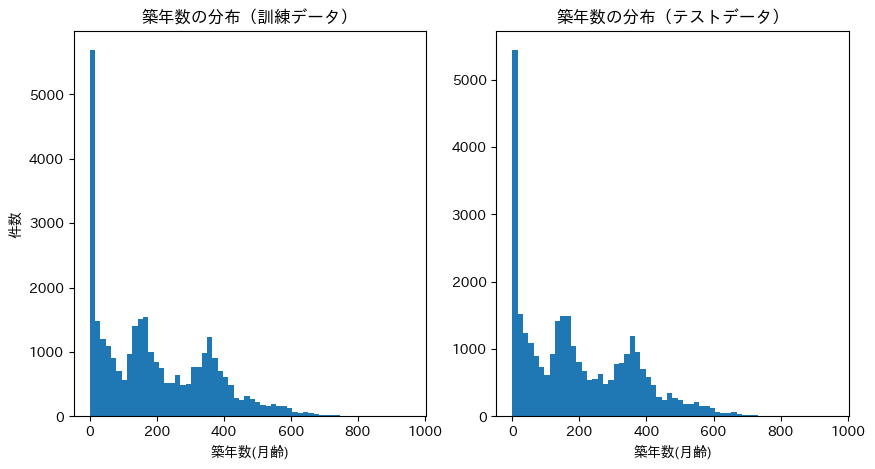

In [731]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(house_age,bins=60)
ax1.set_title('築年数の分布（訓練データ）')
ax1.set_xlabel('築年数(月齢)')
ax1.set_ylabel('件数')

ax2.hist(test_house_age,bins=60)
ax2.set_title('築年数の分布（テストデータ）')
ax2.set_xlabel('築年数(月齢)')

fig.show()

- ここから得られる知見として、築年数ごとの件数でピークがいくつかあるということ。
- 新築の物件が極めて多いこと。

築年数の大きいものが少し怪しい気がするので確かめる。

In [732]:
house_age[house_age['築年数']>800]

,築年数
11994,835.0
13755,819.0
15352,955.0
16506,823.0
17090,819.0
21985,830.0
24000,847.0


元データを確認したところ、築800か月(約70年)超えの物件は少ないながら存在しているのでそのままにする。

面積について

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/1120412897.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


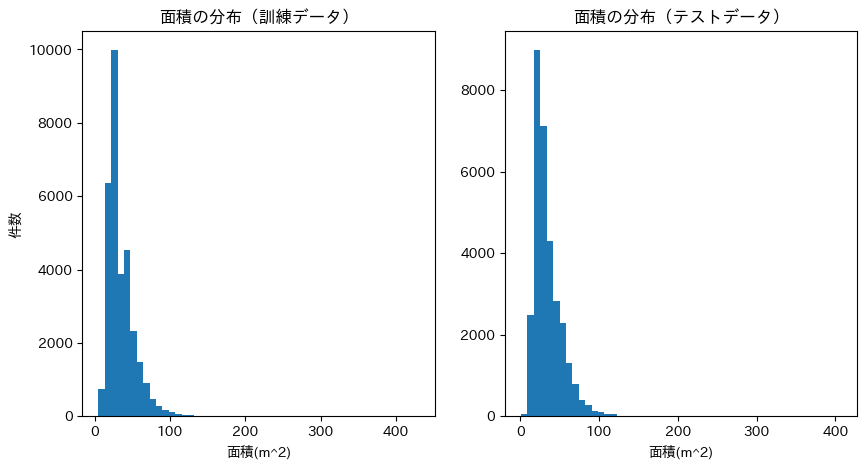

In [733]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(area_size,bins=50)
ax1.set_title('面積の分布（訓練データ）')
ax1.set_xlabel('面積(m^2)')
ax1.set_ylabel('件数')

ax2.hist(test_area_size,bins=50)
ax2.set_title('面積の分布（テストデータ）')
ax2.set_xlabel('面積(m^2)')

fig.show()

面積が大きすぎるものもあるので確認する。

In [734]:
area_size[area_size['面積'] > 200]

,面積
671,231.52
1295,214.78
1771,232.01
2075,256.68
5093,217.29
9008,223.71
10334,214.77
11958,221.30
16613,270.07
16847,221.30


欠損値の処理を見直してみる。

まず自分で欠損値の処理をテキトーにしていた意識があるのは、契約期間である。

In [735]:
contract_span.isna().sum()

契約期間    104
dtype: int64

現在の契約期間データの問題点として、
- 以前は、元ファイルで欠損値になっていたものに0を代入していた。しかしこれでは、モデルに間違った解釈をさせかねない。
- 異常値対策として、契約期間が10年以上のものに対してはnanを代入していた。しかし、例えば1000年のような明らかな異常値はあるものの、15年などのような値も元ファイルに存在している。
- 定期借家情報が抜け落ちている。

これらを修正する。

In [736]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)
merge_contract_span = df["契約期間"]
merge_contract_span.head()

0                       2年間
1                       2年間
2                       2年間
3    2年間\t※この物件は\t定期借家\tです。
4                       2年間
Name: 契約期間, dtype: object

In [737]:
merge_contract_span.isna().sum()

14101

In [738]:
i = 0
target = '年'
target2 = 'ヶ'
merge_reg_rent = []
merge_contract_span2 = []
for contract_span in merge_contract_span:
    ##定期借家かどうかチェックする。    
    try:
        if '定期借家' in contract_span:
            merge_reg_rent.append(1)
        else:
            merge_reg_rent.append(0)
    except:
        merge_reg_rent.append(nan)

    ##以下は契約期間に関する記述。
    #sが欠損値であることに備える。
    try:
        idx = contract_span.find(target)
    except:
        #sが欠損値であればidxの取得が失敗するので、今までは0を代入していた。
        #今回はnanで代入する。
        merge_contract_span2.append(nan)
        i += 1
        continue
    
    try:
        #年単位で契約期間が定まっているのかをまず調べる
        if float( contract_span[:idx] ) > 50.0:
            merge_contract_span2.append(nan)
        else:
            merge_contract_span2.append( float( contract_span[:idx] ) )
    except:
        #月単位で契約期間が定まっているのなら、12で割って契約年数とする。
        idx2 = contract_span.find(target2)
        if float( contract_span[:idx2] )/12 > 50.0:
            merge_contract_span2.append(nan)
        else:
            merge_contract_span2.append(float( contract_span[:idx2] )/12)

    i += 1

In [739]:
merge_reg_rent = pd.DataFrame(merge_reg_rent)

In [740]:
contract_span2 = merge_contract_span2[:len(df_train['契約期間'])]
test_contract_span2 = merge_contract_span2[len(df_train['契約期間']):]
reg_rent = merge_reg_rent[:len(df_train['契約期間'])]
test_reg_rent = merge_reg_rent[len(df_train['契約期間']):]

In [741]:
contract_span2 = pd.DataFrame(contract_span2)
contract_span2.to_csv('contract_span2.csv',index=False)
test_contract_span2 = pd.DataFrame(test_contract_span2)
test_contract_span2.to_csv('test_contract_span2.csv',index=False)

#定期借家はカテゴリ変数
reg_rent = pd.DataFrame(reg_rent)
reg_rent.columns = ['定期借家']
list_cols = ['定期借家']
reg_rent_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
reg_rent = reg_rent_encoder.fit_transform(reg_rent['定期借家'])
reg_rent.to_csv('reg_rent.csv')

test_reg_rent = pd.DataFrame(test_reg_rent)
test_reg_rent.columns = ['定期借家']
test_reg_rent = pd.DataFrame(test_reg_rent)
test_reg_rent_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
test_reg_rent = test_reg_rent_encoder.fit_transform(test_reg_rent['定期借家'])
test_reg_rent.to_csv('test_reg_rent.csv')

次に、「所在地」のカテゴリを振り直す。

In [773]:
#所在地のテキスト整形用関数
def func_place(block):
    target2 = '丁'
    target3 = '町'
    target4 = '-'
    target5 = '－'
    try:
        if target2 in block:
            place = block.split(target2)[0]
            if place == '新宿区余':
                place = '新宿区余丁町'
            else:
                place = place[:-1]
        elif target3 in block:
            place = block.split(target3)[0]
            place = place + target3
        elif target4 in block:
            place = block.split(target4)[0]
            place = place[:-1]
        elif target5 in block:
            place = block.split(target5)[0]
            place = place[:-1]
        if place[-1].isnumeric():
            place = place[:-1]
        return place
    except:
            return block

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)

locations = df['所在地']

#以下の部分では訓練データの”区”のラベル化に備えて、〇〇区の部分を抽出する。
i = 0
merge_addresses = []
for loc in locations:
    target1 = "都"
    idx1 = loc.find(target1)
    block = loc[idx1+1:]
    address = func_place(block)
    merge_addresses.append(address)

merge_addresses = pd.DataFrame(merge_addresses)
merge_addresses = merge_addresses.rename(columns={0:'所在地'})#列名の振り直し
print("カテゴリ化前の訓練データ：")
print(merge_addresses.head(30))
print("カテゴリ化前の訓練データの大きさ：",len(merge_addresses))
merge_addresses.to_csv('merge_address.csv')

#カテゴリ化
list_cols = ['所在地']
addresses_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
merge_addresses_c = addresses_encoder.fit_transform(merge_addresses['所在地'])
#訓練データとテストデータに再分割
addresses = merge_addresses_c[:len(df_train)]
addresses.to_csv('addresses.csv',index=False)
test_addresses = merge_addresses_c[len(df_train):]
test_addresses.to_csv('test_addresses.csv',index=False)

カテゴリ化前の訓練データ：
          所在地
0       北区滝野川
1       中央区月島
2       渋谷区笹塚
3     杉並区高円寺南
4       葛飾区金町
5      荒川区南千住
6      練馬区東大泉
7       目黒区鷹番
8       文京区向丘
9       板橋区板橋
10     大田区西馬込
11    江戸川区北小岩
12      港区南青山
13    杉並区阿佐谷南
14       墨田区緑
15     渋谷区幡ヶ谷
16      板橋区桜川
17    江戸川区西瑞江
18   新宿区四谷三栄町
19  中央区日本橋箱崎町
20     中野区江古田
21      文京区湯島
22       中央区佃
23     大田区大森西
24    江戸川区北小岩
25      豊島区千早
26      台東区台東
27      足立区綾瀬
28     江戸川区船堀
29      渋谷区上原
カテゴリ化前の訓練データの大きさ： 62732


In [774]:
merge_addresses['所在地']

0          北区滝野川
1          中央区月島
2          渋谷区笹塚
3        杉並区高円寺南
4          葛飾区金町
          ...   
62727     豊島区上池袋
62728    千代田区岩本町
62729     中野区江古田
62730    千代田区二番町
62731     大田区南馬込
Name: 所在地, Length: 62732, dtype: object

In [775]:
addresses_sr = pd.Series(merge_addresses['所在地'])
vc = addresses_sr.value_counts()

In [776]:
vc = pd.DataFrame(vc)
vc.columns = ['登場回数']

In [777]:
errors_list = vc[vc['登場回数'] <= 3]
errors_list.to_csv('errors_list.csv')

In [778]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)

origin_addresses = df['所在地']

In [772]:
origin_addresses.to_csv('origin_addresses.csv')

In [779]:
test_addresses.max()

所在地    863
dtype: int64